In [2]:
import torch
from diffusers import SanaSprintPipeline  # or your local import

# --------- Device & dtype ----------
DEVICE = "cuda" 

DTYPE = torch.float16
# --------- Load pipeline ----------
MODEL_ID = "Efficient-Large-Model/Sana_Sprint_1.6B_1024px_diffusers"
pipe = SanaSprintPipeline.from_pretrained(MODEL_ID, dtype=DTYPE)
pipe.to(DEVICE)

Keyword arguments {'dtype': torch.float16} are not expected by SanaSprintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

SanaSprintPipeline {
  "_class_name": "SanaSprintPipeline",
  "_diffusers_version": "0.35.1",
  "_name_or_path": "Efficient-Large-Model/Sana_Sprint_1.6B_1024px_diffusers",
  "scheduler": [
    "diffusers",
    "SCMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "Gemma2Model"
  ],
  "tokenizer": [
    "transformers",
    "GemmaTokenizerFast"
  ],
  "transformer": [
    "diffusers",
    "SanaTransformer2DModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderDC"
  ]
}

In [46]:
b=1
prompt_embeds = torch.zeros((b, 300, 2304), device=DEVICE, dtype=pipe.transformer.dtype)
prompt_attention_mask = torch.ones((b, 300), device=DEVICE, dtype=torch.long)

prompt = "a 3d game asset of a gun"
complex_human_instruction = ["Given a user prompt, generate an 'Enhanced prompt' that provides detailed visual descriptions suitable for image generation. Evaluate the level of detail in the user prompt:", '- If the prompt is simple, focus on adding specifics about colors, shapes, sizes, textures, and spatial relationships to create vivid and concrete scenes.', '- If the prompt is already detailed, refine and enhance the existing details slightly without overcomplicating.', 'Here are examples of how to transform or refine prompts:', '- User Prompt: A cat sleeping -> Enhanced: A small, fluffy white cat curled up in a round shape, sleeping peacefully on a warm sunny windowsill, surrounded by pots of blooming red flowers.', '- User Prompt: A busy city street -> Enhanced: A bustling city street scene at dusk, featuring glowing street lamps, a diverse crowd of people in colorful clothing, and a double-decker bus passing by towering glass skyscrapers.', 'Please generate only the enhanced description for the prompt below and avoid including any additional commentary or evaluations:', 'User Prompt: ']
device = "cuda"
sigma_data = 0.5
(
    prompt_embeds,
    prompt_attention_mask,
) = pipe.encode_prompt(
    prompt,
    num_images_per_prompt=1,
    device=device,
    prompt_embeds=None,
    prompt_attention_mask=None,
    clean_caption=False,
    max_sequence_length=300,
    complex_human_instruction=complex_human_instruction,
)

In [51]:
import torch
from diffusers import SanaSprintPipeline

def sana_one_step_trigflow(
    prompt_embeds: torch.Tensor,
    prompt_attention_mask: torch.Tensor,
    latents: torch.Tensor = None,
    seed: int = 0,
    guidance_scale: float = 1.0,
):
    """
    Single trigflow/SCM + DDIM-like step, then VAE decode.

    - If `latents` is None: sample from N(0, sigma_data^2) with given `seed`.
    - `prompt_embeds` and `prompt_attention_mask` are expected to be pre-encoded
      (e.g. from `pipe.encode_prompt(...)`).
    """

    device = prompt_embeds.device
    dtype_tr = pipe.transformer.dtype

    b = prompt_embeds.shape[0]
    latent_channels = pipe.transformer.config.in_channels
    latent_size = pipe.transformer.config.sample_size  # e.g. 32 for 1024px images

    # --------- Latents init (optional) ----------
    if latents is None:
        g = torch.Generator(device=device).manual_seed(seed)
        latents = torch.randn(
            b,
            latent_channels,
            latent_size,
            latent_size,
            device=device,
            dtype=torch.float32,
            generator=g,
        )
        latents = latents * sigma_data  # N(0, sigma_data^2)

    # --------- ONE trigflow / SCM + "scheduler" step ----------
    with torch.no_grad():
        # Normalize by sigma_data (like your pipeline)
        latent_model_input = latents / sigma_data

        # t ~ pi/2  (max timestep)
        t = torch.tensor(1.571, device=device, dtype=torch.float32)
        timestep = t.expand(b)  # shape [b]

        # SCM timestep & norm
        scm_timestep = torch.sin(timestep) / (torch.cos(timestep) + torch.sin(timestep))
        scm_timestep_expanded = scm_timestep.view(-1, 1, 1, 1)

        norm = torch.sqrt(
            scm_timestep_expanded**2 + (1 - scm_timestep_expanded) ** 2
        )

        # Guidance scalar
        guidance = torch.full((b,), guidance_scale, device=device, dtype=dtype_tr)
        guidance = guidance * pipe.transformer.config.guidance_embeds_scale

        # Transformer forward (eps prediction)
        noise_pred_eps = pipe.transformer(
            latent_model_input.to(dtype=dtype_tr),
            encoder_hidden_states=prompt_embeds.to(dtype=dtype_tr),
            encoder_attention_mask=prompt_attention_mask,
            guidance=guidance,
            timestep=scm_timestep,  # shape [b]
            return_dict=False,
            attention_kwargs=None,
        )[0]

        # SCM combination (same structure as in pipeline)
        noise_pred = (
            (1 - 2 * scm_timestep_expanded) * latent_model_input
            + (1 - 2 * scm_timestep_expanded + 2 * scm_timestep_expanded**2) * noise_pred_eps
        ) / torch.sqrt(scm_timestep_expanded**2 + (1 - scm_timestep_expanded) ** 2)

        noise_pred = noise_pred.float() * sigma_data

        # --- Your "scheduler one step" hack ---
        # pred_x0 = alpha_t * x_t - sigma_t * eps_t
        alpha_t = 0.267
        sigma_t = 0.964

        pred_x0 = alpha_t * latents - sigma_t * noise_pred  # same as your code
        pred_x0 = pred_x0 / sigma_data  # back to VAE latent scale
        pred_x0 = pred_x0.to(pipe.vae.dtype)

        # --------- Decode with VAE ----------
        image_tensor = pipe.vae.decode(
            pred_x0 / pipe.vae.config.scaling_factor,
            return_dict=False,
        )[0]

    images = pipe.image_processor.postprocess(image_tensor, output_type="pil")
    return images



In [76]:
zeros_prompt_embeds = torch.zeros(prompt_embeds.shape,device =prompt_embeds.device)


In [84]:
x_1 =sana_one_step_trigflow(prompt_embeds,prompt_attention_mask, seed = 1,
    guidance_scale=1.0)

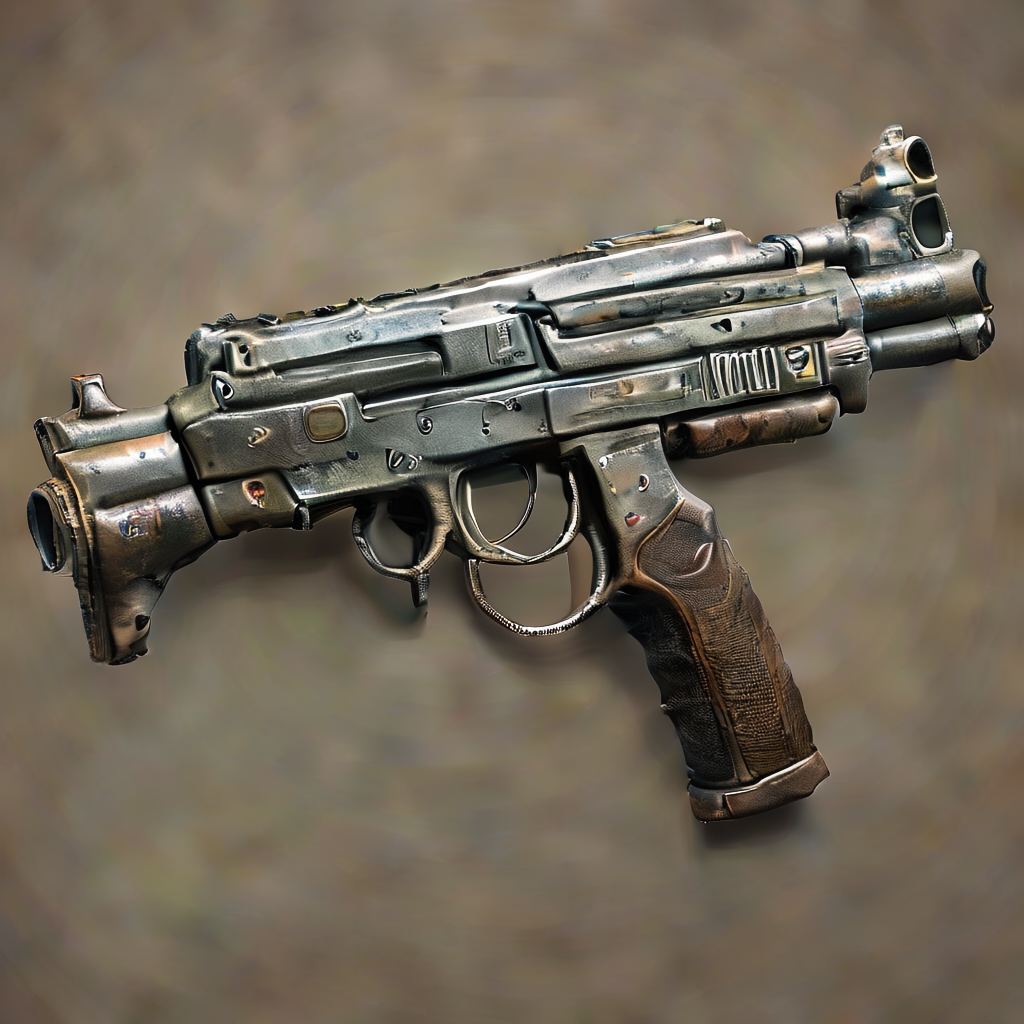

In [85]:
x_1[0]